In [ ]:
!pip install tensorflow==2.14.1
!pip install tensorflow-estimator==2.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [ ]:
!pip install tensorflow-privacy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.1 which is incompatible.
xarray 2024.9.0 requires packaging>=23.1, but you have packaging 22.0 which is incompatible.


In [ ]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler


#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load and Preprocess Data

In [ ]:
data  = pd.read_csv('/content/drive/MyDrive/RT_IOT2022.csv', index_col = 0)

In [ ]:
# Multiclass problem
target_column = 'Attack_type'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

In [ ]:
data[target_column].value_counts()

In [ ]:
# Lets keet top 3 groups and implement imbalancing
# simplify the problem lets only predict for top 3 conditions
data = data[data[target_column].isin(['DOS_SYN_Hping','Thing_Speak','ARP_poisioning'])]

In [ ]:
# Add Upsampling
# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Perform upsampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
# Label encode the target column
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data[target_column] = label_encoder.fit_transform(data[target_column])

In [ ]:
# Identify non-numeric columns (only two so dropping)
print(data.select_dtypes(include='object').columns)

data.drop(['proto', 'service'], axis=1, inplace=True)

In [ ]:
target_column = 'Attack_type'
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

## PATE Default MLP Model

In [ ]:
# mlp_model = Sequential()
# Define teacher model architecture
def create_teacher_model(input_shape, num_classes):
    model = Sequential([
        Dense(288, activation="relu", input_shape=input_shape),
        Dropout(0.2),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

# Define student model architecture
def create_student_model(input_shape, num_classes):
    model = Sequential([
        Dense(288, activation="relu", input_shape=input_shape),
        Dropout(0.2),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model
# # Add the first dense layer with dropout
# mlp_model.add(Dense(32, activation='relu', input_shape=(len(categorical_columns),)))
# mlp_model.add(Dropout(0.5))

# # Add the second dense layer with dropout
# mlp_model.add(Dense(32, activation='relu'))
# mlp_model.add(Dropout(0.5))

# Define hyperparameters
num_teachers = 1
input_shape = (len(categorical_columns),)
epsilon = 1.0
kfolds = 2
epoch_num = 2

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train teacher models for this fold
    teacher_models = []
    for i in range(num_teachers):
        teacher_model = create_teacher_model(input_shape, num_classes)
        teacher_model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])
        teacher_model.fit(X_train_fold, y_train_fold, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed
        teacher_models.append(teacher_model)

    # Generate labels for the training data using teacher models
    def generate_labels(data):
        labels = []
        for model in teacher_models:
            labels.append(np.argmax(model.predict(data), axis = 1))
        return labels

    # Define your student model
    student_model = create_student_model(input_shape, num_classes)
    student_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

    # Generate labels for the training data using teacher models
    train_labels = generate_labels(X_train_fold)
    student_y_train_fold = pd.Series(train_labels[0], index = y_train_fold.index)

    # Train the student model using the labels generated by the teacher models
    student_model.fit(X_train_fold, student_y_train_fold, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed

    # Evaluate the student model on the validation set
    val_loss, val_accuracy = student_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit the full model on the entire training set
teacher_models = []
for i in range(num_teachers):
    teacher_model = create_teacher_model(input_shape, num_classes)
    teacher_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
    teacher_model.fit(X_train_scaled[categorical_columns], y_train, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed
    teacher_models.append(teacher_model)

# Generate labels for the training data using teacher models
def generate_labels(data):
    labels = []
    for model in teacher_models:
        labels.append(np.argmax(model.predict(data), axis = 1))
    return labels

# Define your student model
student_model = create_student_model(input_shape, num_classes)
student_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Generate labels for the training data using teacher models
train_labels = generate_labels(X_train_scaled[categorical_columns])
student_train_labels = pd.Series(train_labels[0], index = X_train_scaled.index)

# Train the student model using the labels generated by the teacher models
model_history =  student_model.fit(X_train_scaled[categorical_columns], student_train_labels, epochs=epoch_num, batch_size=32, validation_split = 0.2)  # Adjust epochs and batch_size as needed

# Evaluate the student model on the test set
test_loss, test_accuracy = student_model.evaluate(X_test_scaled[categorical_columns], y_test)

# Predict on the test data
y_test_pred_mlp = student_model.predict(X_test_scaled[categorical_columns])

# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred_mlp, axis=1)

Epoch 1/2
3328/3328 [==============================] - 15s 4ms/step - loss: 0.0833 - accuracy: 0.9711
Epoch 2/2
3328/3328 [==============================] - 6s 2ms/step
Epoch 1/2
3328/3328 [==============================] - 15s 4ms/step - loss: 0.0702 - accuracy: 0.9766
Epoch 2/2
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0699 - accuracy: 0.9884
Epoch 1/2
3328/3328 [==============================] - 15s 4ms/step - loss: 0.0840 - accuracy: 0.9705
Epoch 2/2
3328/3328 [==============================] - 5s 2ms/step
Epoch 1/2
3328/3328 [==============================] - 15s 4ms/step - loss: 0.0634 - accuracy: 0.9777
Epoch 2/2
3328/3328 [==============================] - 6s 2ms/step - loss: 0.0907 - accuracy: 0.9864
Epoch 1/2
6656/6656 [==============================] - 29s 4ms/step - loss: 0.0635 - accuracy: 0.9781
Epoch 2/2
6656/6656 [==============================] - 13s 2ms/step
Epoch 1/2
5325/5325 [==============================] - 25s 4ms/step - loss: 0.0523 - a

In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.08032641559839249
Average cross-validation accuracy: 0.9874120950698853
MLP Model:
Accuracy =  0.9823226987816044
Precision = 0.9823681733583762
Recall = 0.9824046342884563
F1 Score =  0.982366914804155


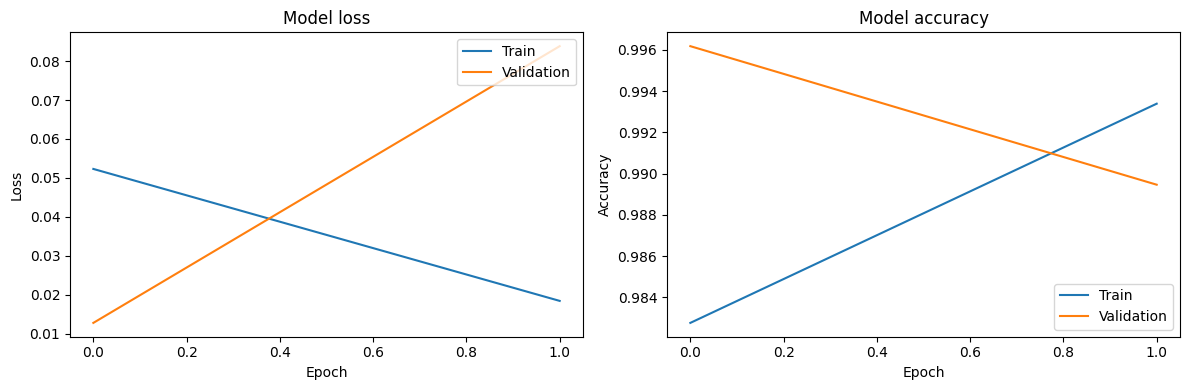

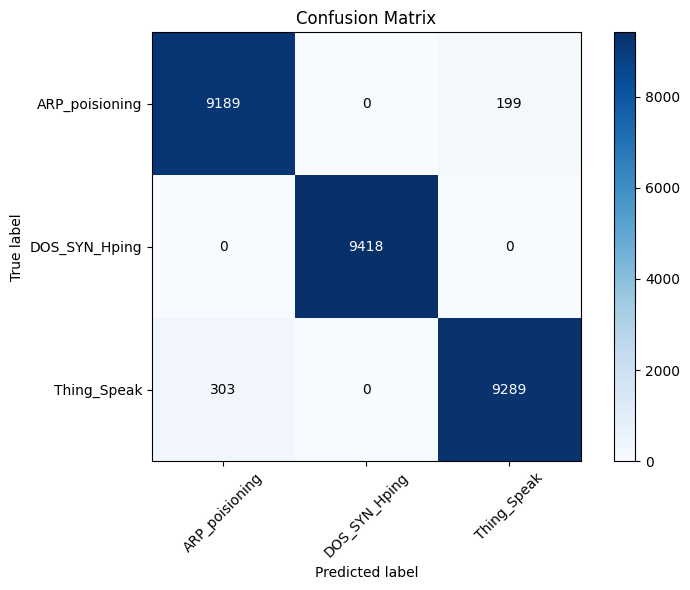

In [ ]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve (Not possible for Multiclass Classification, it is designed for Binary Class only)
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_mlp)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

## PATE Privacy

In [ ]:
# Define your teacher model architecture
def create_teacher_model(input_shape, num_classes):
    model = Sequential([
        Dense(288, activation="relu", input_shape=input_shape),
        Dropout(0.2),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

# Define differential privacy parameters
batch_size = 16
l2_norm_clip = 1.0
noise_multiplier = 1.3
num_microbatches = 1

# Create a DP optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.003
)

# Define your student model architecture with differential privacy
def create_student_model_privacy(input_shape, num_classes):
    model = Sequential([
        Dense(288, activation="relu", input_shape=input_shape),
        Dropout(0.2),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax"),
        Dense(num_classes, activation="softmax")  # Add an additional layer for differential privacy
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Define hyperparameters
num_teachers = 1
input_shape = (len(categorical_columns),)
epsilon = 1.0
kfolds = 2
epoch_num = 2

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train teacher models for this fold
    teacher_models = []
    for i in range(num_teachers):
        teacher_model = create_teacher_model(input_shape, num_classes)
        teacher_model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])
        teacher_model.fit(X_train_fold, y_train_fold, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed
        teacher_models.append(teacher_model)

    # Generate labels for the training data using teacher models
    def generate_labels(data):
        labels = []
        for model in teacher_models:
            labels.append(np.argmax(model.predict(data), axis = 1))
        return labels

    # Define your student model
    student_model_privacy = create_student_model_privacy(input_shape, num_classes)
    student_model_privacy.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

    # Generate labels for the training data using teacher models
    train_labels = generate_labels(X_train_fold)
    student_y_train_fold = pd.Series(train_labels[0], index = y_train_fold.index)

    # Train the student model using the labels generated by the teacher models
    student_model_privacy.fit(X_train_fold, student_y_train_fold, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed

    # Evaluate the student model on the validation set
    val_loss, val_accuracy = student_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit the full model on the entire training set
teacher_models = []
for i in range(num_teachers):
    teacher_model = create_teacher_model(input_shape, num_classes)
    teacher_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
    teacher_model.fit(X_train_scaled[categorical_columns], y_train, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed
    teacher_models.append(teacher_model)

# Generate labels for the training data using teacher models
def generate_labels(data):
    labels = []
    for model in teacher_models:
        labels.append(np.argmax(model.predict(data), axis = 1))
    return labels

# Define your student model
student_model_privacy = create_student_model_privacy(input_shape, num_classes)
student_model_privacy.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Generate labels for the training data using teacher models
train_labels = generate_labels(X_train_scaled[categorical_columns])
student_train_labels = pd.Series(train_labels[0], index = X_train_scaled.index)

# Train the student model using the labels generated by the teacher models
model_history_privacy =  student_model_privacy.fit(X_train_scaled[categorical_columns], student_train_labels, epochs=epoch_num, batch_size=32, validation_split = 0.2)  # Adjust epochs and batch_size as needed

# Evaluate the student model on the test set
test_loss, test_accuracy = student_model_privacy.evaluate(X_test_scaled[categorical_columns], y_test)


Epoch 1/2
3328/3328 [==============================] - 15s 4ms/step - loss: 0.0795 - accuracy: 0.9729
Epoch 2/2
3328/3328 [==============================] - 6s 2ms/step
Epoch 1/2
3328/3328 [==============================] - 16s 4ms/step - loss: 0.5103 - accuracy: 0.9163
Epoch 2/2
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1395 - accuracy: 0.9827
Epoch 1/2
3328/3328 [==============================] - 15s 4ms/step - loss: 0.0798 - accuracy: 0.9723
Epoch 2/2
3328/3328 [==============================] - 7s 2ms/step
Epoch 1/2
3328/3328 [==============================] - 16s 4ms/step - loss: 0.4184 - accuracy: 0.8948
Epoch 2/2
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1595 - accuracy: 0.9823
Epoch 1/2
6656/6656 [==============================] - 29s 4ms/step - loss: 0.0609 - accuracy: 0.9791
Epoch 2/2
6656/6656 [==============================] - 12s 2ms/step
Epoch 1/2
5325/5325 [==============================] - 25s 5ms/step - loss: 0.5836 - a

In [ ]:
# Predict on the test data
y_test_pred_mlp_privacy = student_model_privacy.predict(X_test_scaled[categorical_columns])

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

888/888 [==============================] - 2s 2ms/step


In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 0.1494787037372589
Average cross-validation accuracy: 0.9824961721897125
MLP Model:
Accuracy =  0.6610676808225932
Precision = 0.4518436340392127
Recall = 0.6584075233053571
F1 Score =  0.5330612012664959


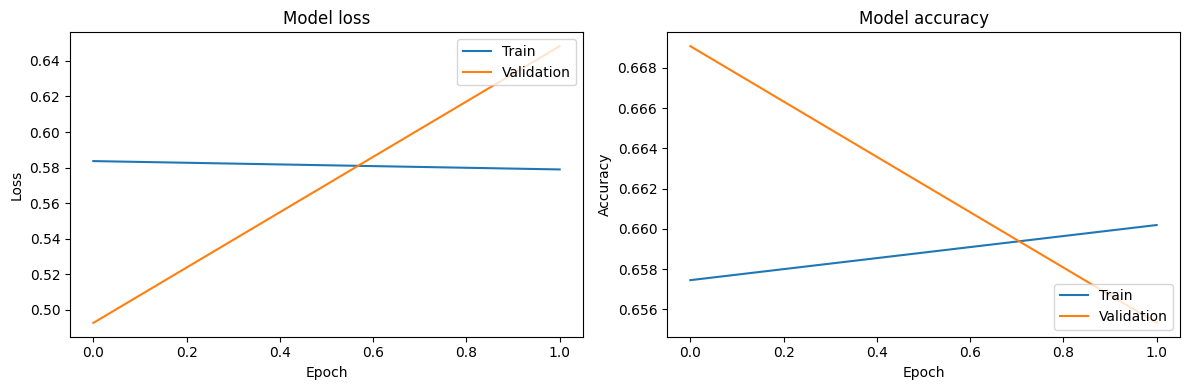

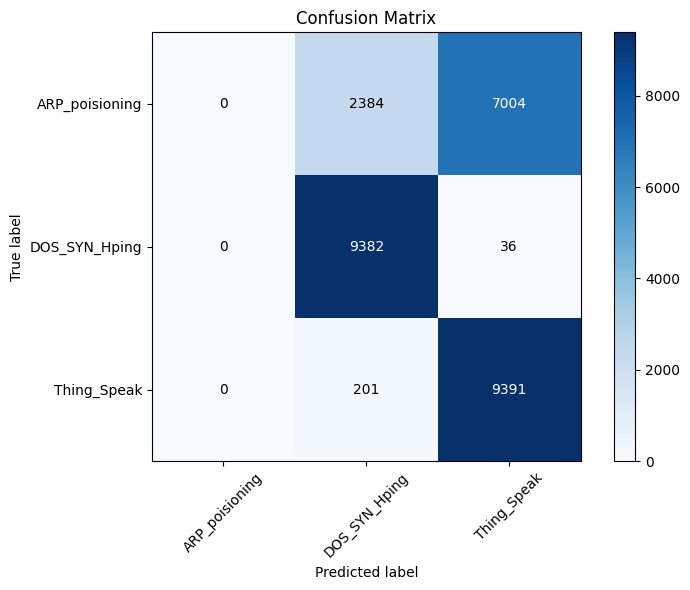

In [ ]:
# Plot loss curves
plot_loss(model_history_privacy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_binary_mlp_privacy)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Privacy Model Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

In [ ]:
# Extract trainable variables from the model
trainable_variables = student_model_privacy.trainable_variables

# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=30,
    delta=1e-5
)

In [ ]:
print(privacy_report)

DP-SGD performed over 212982 examples with 16 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      1.466

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



## Combine

In [ ]:
# Create DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Regular': [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp],
    'Privacy': [accuracy_mlp_privacy, precision_mlp_privacy, recall_mlp_privacy, f1_mlp_privacy]
}

df = pd.DataFrame(data)

# Print DataFrame
display(df)

,Metric,Regular,Privacy
0,Accuracy,0.982323,0.661068
1,Precision,0.982368,0.451844
2,Recall,0.982405,0.658408
3,F1 Score,0.982367,0.533061


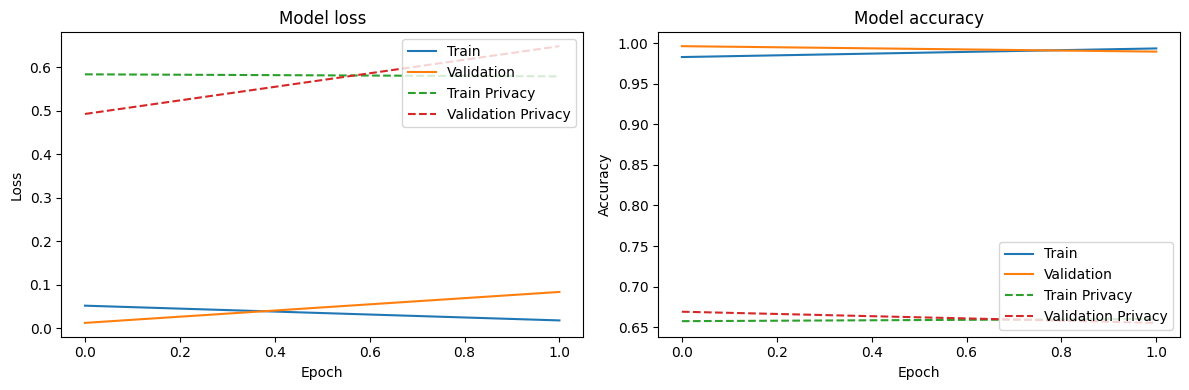

In [ ]:
plot_loss(model_history, model_history_privacy)